## Codificação de Sinais Multimédia
### Licenciatura em Engenharia Informática e Multimédia
#### Instituto Superior de Engenharia de Lisboa
#### *4º Trabalho Prático*







<a name="intro"></a>
# Codificação MPEG
---
Neste último trabalho prático, serão implementados três codificadores de vídeo com base nos codificadores estudados nas aulas. A ideia fundamental da codificação de vídeo nasce da necessidade de comprimir conteúdos que possuem uma grande quantidade de informação, para que possam ser mais rapidamente processados, armazenados ou até mesmo partilhados.  Os algoritmos de compressão de vídeo exploram principalmente, o facto de que na maior parte dos casos existir pouco movimento nos objetos que compõe a cena. Se considerarmos que um vídeo num formato *standard* é reproduzido entre 24 a 30 frames por segundo, e analisarmos algumas amostras de frames, depressa se percebe que na maior parte do tempo a cena permanece a mesma e apenas alguns objetos se movimentam. Assim ao invés de enviar ou processar todas as frames de igual forma, podemos criar algoritmos que processam apenas a diferença entre cada frame enviando apenas os objetos que se movem. Será também possível haver predição do movimento dos objetos contidos na cena e por consequência comprimir ainda mais a informação processada. 

Dado que um vídeo é um conjunto de imagens, é possível numa primeira fase aplicar os conceitos aprendidos no trabalho prático anterior, e comprimir cada frame usando uma codificação JPEG. Posteriormente será feita uma conversão do espaço de cores de RGB para YCC de maneira a que se consiga extrair a informação da luminosidade para um componente separado dos componentes de cor, usando assim as limitações do cérebro a nosso favor.  Será feito um chroma-subsampling para reduzir ainda mais a entropia das frames. A codificação das frames que constituem o vídeo será feita em termos espaciais, usando os processos de compressão de imagem, e em termos temporais, isto é, irá ser feita a diferença entre frames, removendo assim a redundância temporal. Isto é possível porque ao analisar a maior parte dos vídeos percebe-se que existe uma grande quantidade de pixéis que se mantém inalterados ao longo de uma sequência de *frames*. Um exemplo comum nota-se nas comunicações via webcam, onde a imagem permanece inalterada ao longo do tempo com exceção do movimento da pessoa que está a ser gravada.  Isto deixa de ser possível quando o plano se altera ou a quantidade de movimento é tão alta que deixa de ser viável processar as frames de um ponto de vista de compressão, e é preferível enviar ou processar a frame completa. Neste caso, o processo de compressão é reiniciado, e uma nova *frame* de referência (*intraframe*) será atualizada. Este processo de seleção de *frame* é facilmente explicado observando o esquema algorítmico do codificador/descodificador:

Ao processar a frame de referência usando a transformada DCT e quantizando o resultado para diminuir a gama de variação do valor dos pixeis, é realizado o cálculo do movimento predito para a proxima frame, resultando num vector que irá conter a informação da posição original do objecto na imagem, bem como a localização futura deste. Este passo é fundamental para garantir uma compressão que não só elimina informação reduntante da imagem, mas que também consegue estimar/compensar o movimento relaizado por um determinado objecto na cena. Esta codificação é feita, à semelhança do que acontece com algoritmo JPEG, por blocos de 16x16 para o caso da frame que contêm a informação da luminância e blocos de 8x8 para as frames que contém a crominancia.  Esta é um passo fundamental pois não seria possível fazer a deteção de movimento caso a imagem não fosse analisada em pequenos blocos pois a deteção de movimento é realizada usando uma procura exaustiva em cada bloco, comparando o erro quadrático médio entre blocos das *frames* e uma janela de pesquisa (-15 a 15 pixeis) para obter o vector de movimento ótimo de cada bloco da *frame*. 

In [1]:
import os
import cv2
import sys
import math
import time
import psutil
import humanize
import resource
import traceback
import numpy as np
!pip install GPUtil
import GPUtil as GPU
from pprint import pprint
from enum import Enum, unique
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from abc import ABC, abstractmethod
from google.colab import drive, widgets
from google.colab.patches import cv2_imshow
from sklearn.metrics import mean_squared_error

  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil


In [2]:
class Notebook():
    """Holds notebook methods and variables."""
    ROOT = '/content/drive'
    PROJECT = '{}/My Drive/CSM/isel_leim_csm_1819/projects/P04'.format(ROOT)
    LIBRARY = '{}/My Drive/CSM/isel_leim_csm_1819/projects/lib'.format(ROOT)
    NOTEBOOK = '{}/notebooks/'.format(PROJECT)
    RESOURCES = '{}/resources/raw/'.format(PROJECT)
    REFERENCES = '{}/references/'.format(PROJECT)
    ENCODED = '{}/resources/encoded/'.format(PROJECT)
    DECODED = '{}/resources/decoded/'.format(PROJECT)
    GPU = GPU.getGPUs()
    PROCESS = psutil.Process(os.getpid())
    
    @classmethod
    def mount(cls):
        """Mounts the (Google) drive in this runtime, all files/folders will be available."""
        drive.mount("/content/drive", force_remount=True)
        for path in [cls.ROOT, cls.PROJECT, 
                     cls.LIBRARY, cls.NOTEBOOK, 
                     cls.RESOURCES, cls.REFERENCES,
                     cls.ENCODED, cls.DECODED]:
            try:
                assert os.path.isdir(path), 'Directory not found.'
                sys.path.insert(0, path) #To allow for direct imports
            except AssertionError:
                _, _, tb = sys.exc_info()
                tb_info = traceback.extract_tb(tb)
                filename, line, func, text = tb_info[-1]
                print('An error occurred on line {} in statement {}:'.format(line, text))
                sys.exit(0)
    
    @classmethod
    def memory(cls):
        """Checks the RAM resources available in this runtime, including peak usage stats."""
        print('Gen Available RAM: {} | Process Memory Size: {} | Peak Usage: {} MB'
            .format(
                humanize.naturalsize(psutil.virtual_memory().available), 
                humanize.naturalsize(cls.PROCESS.memory_info().rss),
                resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1000.))
        for g in cls.GPU:
            print('GPU Available RAM: {0:.1f} GB | Used: {1:.1f} GB | Util {2:0.0f}% | Total {3:.1f} GB'
                .format(
                    g.memoryFree/1000., g.memoryUsed/1000., g.memoryUtil/10., g.memoryTotal/1000.))
    
Notebook.mount()
Notebook.memory()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
Gen Available RAM: 12.9 GB | Process Memory Size: 168.5 MB | Peak Usage: 164.596 MB
GPU Available RAM: 15.1 GB | Used: 0.0 GB | Util 0% | Total 15.1 GB


In [0]:
class Frame(ABC):
    """Abstract class representing a frame composed of a n-dimensional (multi-channel) numpy array."""
    
    @abstractmethod
    def __init__(self, pixels: np.ndarray, index: int) -> None:
        self.__index = index
        self.__pixels = pixels

    def __repr__(self) -> str:
        return "Frame({})".format(self.__index)

    def __sub__(self, other):
        return self.__pixels - other.pixels

    def __getitem__(self, item) -> np.uint8:
        return self.__pixels[item]

    @property
    def index(self) -> int:
        return self.__index

    @property
    def shape(self) -> tuple:
        return self.__pixels.shape

    @property
    def size(self) -> int:
        return self.__pixels.size

    @property
    def pixels(self) -> np.ndarray:
        return self.__pixels
    
    @pixels.setter
    def pixels(self, pixels: np.ndarray) -> None:
        self.__pixels = pixels

    def write(self, path: str, quality: int) -> None:
        cv2.imwrite(path, self.__pixels, (cv2.IMWRITE_JPEG_QUALITY, quality))

In [0]:
class YCCFrame(Frame):
    """Specific frame defining class with YCC layers in each of its channels - for BGR-YCC conversion."""
    
    def __init__(self, pixels: np.ndarray, index: int) -> None:
        super().__init__(pixels, index)
        self.__layers = np.array([
            LuminanceLayer(pixels[:, :, 0]),
            ChrominanceLayer(pixels[:, :, 1]),
            ChrominanceLayer(pixels[:, :, 2]),
        ])

    def __sub__(self, other):
        return super().__sub__(other)

    def __str__(self) -> str:
        return "Luminance: {}\n\nChrominance B: {}\n\nChrominance R: {}".format(
            self.__layers[0].__str__(),
            self.__layers[1].__str__(),
            self.__layers[2].__str__(),
        )

    @property
    def layers(self) -> np.ndarray:
        return self.__layers

In [0]:
class Layer:
    """Class defining an image channel as a layer with channel info."""
    #
    # For precaution, if you need the original object (self.__blocks) unchanged when
    # the new object returned from this method as a variable eventually is modified, 
    # you should return a copy(). This is called a shallow copy. If there is inner 
    # structure, will still be an equivalent reference between source and variable.
    # For encoding purposes, it needs to trim pixels to block size modulus.
    # Such trimmed pixels, should be recovered as weighted average from 
    # neighbouring pixels on the receiver side, when implemented.
    #
    # Function make_blocks() first calculates number of blocks needed for the whole 
    # multi-channel image (as frame with inner layers) and inits up a numpy array to 
    # act as container. Then constructs a Block with frame origin as each row and columns 
    # times total number of blocks and Block origin as each row and column. Luminance has 
    # 16x16 pixels Blocks, Chrominance has 8x8 pixels blocks, as the norm states. The point 
    # is to restrict the amount of processing needed for searching chrominance while 
    # also reducing the prediction vector available to transmit in chrominance. Overall, 
    # conjoined with chroma subsampling 4:2:2, this adapts perfectly to JPEG compression.
    # 
    # Variable r1 is the row start of the Block, c1 is the column start of the Block, r2 is the 
    # row end of the Block and c2 is the column start of the Block. Then constructs a block 
    # using common slicing and adds respective origins, for searching purposes. For top 
    # left corner and first iteration, Frame origin (r1, c1) will be (0, 0) as will Block 
    # origin with (r, c) will also be (0, 0).
    #
    
    def __init__(self, pixels: np.ndarray, block_size: int) -> None:
        self.__block_size = block_size
        self.__pixels = pixels
        self.__blocks = None
        self.__trim_pixels()
        self.__make_blocks()

    def __str__(self) -> str:
        return self.__pixels.__str__()

    def __sub__(self, other):
        if self.__blocks is not None and other.__blocks is not None:
            self.__blocks - other.__blocks

        return self.__pixels - other.__pixels

    @property
    def blocks(self) -> np.ndarray:    
        return self.__blocks.copy()

    @property
    def shape(self) -> tuple:
        return self.__pixels.shape

    @property
    def pixels(self) -> np.ndarray:
        return self.__pixels.copy()

    def __trim_pixels(self) -> None:
        rows_value = self.__pixels.shape[0] % self.__block_size
        cols_value = self.__pixels.shape[1] % self.__block_size
        total_rows = self.__pixels.shape[0] - rows_value
        total_cols = self.__pixels.shape[1] - cols_value
        self.__pixels = self.__pixels[0: total_rows, 0: total_cols]

    def __make_blocks(self) -> None:
        self.__blocks = np.array([Block] * int((self.__pixels.shape[0] * self.__pixels.shape[1]) \
            / (self.__block_size * self.__block_size))).reshape((int(self.__pixels.shape[0] \
            / self.__block_size), int(self.__pixels.shape[1] / self.__block_size)))
        for r in range(self.__blocks.shape[0]):
            for c in range(self.__blocks.shape[1]):
                r1 = r * self.__block_size
                c1 = c * self.__block_size
                r2 = r * self.__block_size + self.__block_size
                c2 = c * self.__block_size + self.__block_size
                self.__blocks[r, c] = Block(self.__pixels[r1: r2, c1: c2], (r1, c1), (r, c), 
                                            self.__block_size)

In [0]:
class LuminanceLayer(Layer):
    """Class defining macroblock size for luminance."""
    
    BLOCK_SIZE = 16

    def __init__(self, pixels: np.ndarray) -> None:
        super().__init__(pixels, LuminanceLayer.BLOCK_SIZE)
        
    def __repr__(self) -> str:
        return "Luminance Layer ({}x{} Macroblocks)".format(LuminanceLayer.BLOCK_SIZE, 
                                                    LuminanceLayer.BLOCK_SIZE)

class ChrominanceLayer(Layer):
    """Class defining macroblock size for chrominance."""
    
    BLOCK_SIZE = 8

    def __init__(self, pixels: np.ndarray) -> None:
        super().__init__(pixels, ChrominanceLayer.BLOCK_SIZE)

    def __repr__(self) -> str:
        return "Chrominance Layer ({}x{} Macroblock)".format(ChrominanceLayer.BLOCK_SIZE, 
                                                      ChrominanceLayer.BLOCK_SIZE)

In [0]:
class Block:
    """Class defining a macro block, for searching purposes."""
    #
    # Method __repr__ is the formal method to represent object as abstraction, through 
    # repr(Block()). By default, when IPython displays an object, it seems to use __repr__.
    # __repr__ is supposed to produce a unique string which could be used to reconstruct an 
    # object, given the right environment. This is distinct from __str__, which supposed to 
    # produce human-readable output, by print(Block()).
    # 
    # Frame origin is where this block starts in the frame. Block origin is where the searching 
    # cursor starts. Frame target is where its motion prediction sets it up to be.
    #
    
    def __init__(self, pixels: np.ndarray, frame_origin: tuple, block_origin: tuple, size: int) -> None:
        self.__pixels: np.ndarray = pixels
        self.__frame_origin: tuple = frame_origin
        self.__frame_target: tuple = None
        self.__block_origin: tuple = block_origin
        self.__size: int = size

    def __sub__(self, other) -> np.ndarray:
        return self.__pixels - other.__pixels

    def __str__(self) -> str:
        return "{}".format(self.__pixels)

    def __repr__(self) -> str:
        return "Origin: ({}), Target: ({})".format(self.__frame_origin, self.__frame_target)

    @property
    def origin(self) -> tuple:
        return self.__frame_origin, self.__block_origin

    @property
    def target(self) -> tuple:
        return self.__frame_target

    @target.setter
    def target(self, value) -> None:
        self.__frame_target = value

    @property
    def pixels(self) -> np.ndarray:
        return self.__pixels.copy()

    @property
    def shape(self) -> tuple:
        return self.__pixels.shape

    @property
    def size(self) -> int:
        return self.__size


In [0]:
class Vectors:
    """Class defining a vector, video prediction motion and block realignment."""
    
    def __init__(self, vectors: np.ndarray) -> None:
        self.__vectors = vectors

    @property
    def vectors(self) -> np.ndarray:
        return self.__vectors

    @vectors.setter
    def vectors(self, vectors) -> None:
        self.__vectors = vectors

    def __getitem__(self, item) -> np.uint8:
        return self.__vectors[item]

    def __setitem__(self, index, value) -> None:
        self.__vectors[index] = value

In [0]:
#@title *YCCFrame Class* (demonstração)
Help = False #@param {type:"boolean"}
a = np.array([
            [ [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], ],
            [ [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], ],
            [ [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], ],
            [ [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], ],
            [ [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], ],
            [ [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], ],
            [ [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], ],
            [ [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], ], 
             ])
b = 1
c = YCCFrame(a, b)
if(Help):
    help(c)
print('Frame Dimensions: {}x{}'.format(c.shape[0], c.shape[1]))
print('Frame Number: {}'.format(c.index))
print('First Pixel: {}'.format(c[0, 0, :]))

Frame Dimensions: 8x8
Frame Number: 1
First Pixel: [128 128 128]


In [0]:
#@title *Layer Class* (demonstração)
Help = False #@param {type:"boolean"}
b = 8
a = np.array([
            [ 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128  ],
             ])

c = Layer(a, b)
if(Help):
    help(c)
print('Input Image Dimensions: {}x{}'.format(a.shape[0], a.shape[1]))
print('Input Image:')
print(a)
print('Layer Dimensions: {}x{}'.format(c.shape[0], c.shape[1]))
print('Number of {}x{} Blocks Generated: {}'.format(b, b, c.blocks.size))
print('Layer:')
print(c)
print('Blocks: ')
pprint(c.blocks)

Input Image Dimensions: 17x16
Input Image:
[[128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128]
 [128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128]
 [128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128]
 [128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128]
 [128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128]
 [128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128]
 [128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128]
 [128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128]
 [128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128]
 [128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128]
 [128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128]
 [128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128]
 [128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128]
 [128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128]
 [128 128 128 128 1

In [0]:
#@title *LuminanceLayer Class* (demonstração)
Help = False #@param {type:"boolean"}
x = LuminanceLayer(np.array([[1, 2, 3, 4, 5, 6, 7, 8]]))
repr(x)
if(Help):
    help(x)

In [0]:
#@title *Block Class* (demonstração)
Help = False #@param {type:"boolean"}
a = np.array([
            [ 128, 128, 128, 128, 128, 128, 128, 128 ],
            [ 128, 128, 128, 128, 128, 128, 128, 128 ],
            [ 128, 128, 128, 128, 128, 128, 128, 128 ],
            [ 128, 128, 128, 128, 128, 128, 128, 128 ],
            [ 128, 128, 128, 128, 128, 128, 128, 128 ],
            [ 128, 128, 128, 128, 128, 128, 128, 128 ],
            [ 128, 128, 128, 128, 128, 128, 128, 128 ],
            [ 128, 128, 128, 128, 128, 128, 128, 128 ],
            ])
b = (0, 0)
c = (0, 0)
d = 8
e = Block(a, b, c, d)
if(Help):
    help(e)
e.target = (7, 7)
print('Input Pixels:')
print(a)
print('Block Dimensions: {}x{}'.format(e.shape[0], e.shape[1]))
print('Block: {}'.format(repr(e)))

Input Pixels:
[[128 128 128 128 128 128 128 128]
 [128 128 128 128 128 128 128 128]
 [128 128 128 128 128 128 128 128]
 [128 128 128 128 128 128 128 128]
 [128 128 128 128 128 128 128 128]
 [128 128 128 128 128 128 128 128]
 [128 128 128 128 128 128 128 128]
 [128 128 128 128 128 128 128 128]]
Block Dimensions: 8x8
Block: Origin: ((0, 0)), Target: ((7, 7))


In [0]:
#@title *Vectors Class* (demonstração)
Help = False #@param {type:"boolean"}
x = Vectors(np.array([0, 0]))
if(Help):
    help(x)
print('Vectors: {}'.format(x[:]))

Vectors: [0 0]


In [0]:
class SearchStrategy:
    
    @abstractmethod
    def __init__(self):
        pass
    
    @abstractmethod
    def find_similar(self, block: Block, layer: Layer) -> (Block, float):
        pass

    @staticmethod
    def mean_squared_error(oblock: Block, block: Block) -> float:
        return mean_squared_error(oblock.pixels, block.pixels)
    
    @staticmethod
    def mean_absolute_error(oblock: Block, sblock: Block) -> float:
        return np.sum(cv2.absdiff(oblock.pixels, sblock.pixels)) / oblock.size**2

    @staticmethod
    def _find_smallest_error(errors: np.ndarray):
        min_error = np.min(errors)
        if min_error > 100:
            print("OK")
            print()
        r, c = np.argwhere(errors == min_error)[0]
        return r, c, min_error

class Iterative(SearchStrategy):
    def find_similar(self, block: Block, layer: Layer) -> (Block, float):
        blocks = layer.blocks
        errors = np.array([np.inf] * blocks.shape[0] * blocks.shape[1]).reshape(blocks.shape)       
        for r in range(blocks.shape[0]):
            for c in range(blocks.shape[1]):
                errors[r, c] = self.mean_absolute_error(blocks[r, c], block)
        r, c, min_error = self._find_smallest_error(errors)
        return blocks[r, c], r, c, min_error
    
class Exhaustive(SearchStrategy):
    SEARCH_WINDOW = 15
    def find_similar(self, block: Block, layer: Layer) -> (Block, float):
        # Original block coordinates
        r, c = block.origin[0]
        pixels: np.ndarray = layer.pixels
        block_size = layer.blocks[0, 0].size
        total_errors = int(math.pow(2 * Exhaustive.SEARCH_WINDOW + 2, 2))
        errors = np.array([np.inf] * total_errors).reshape(
            (int(math.sqrt(total_errors)), int(math.sqrt(total_errors))))
        blocks = np.array([Block] * total_errors).reshape(
            (int(math.sqrt(total_errors)), int(math.sqrt(total_errors))))
        # Indexes for errors and blocks
        r2 = -1
        c2 = -1
        for r1 in range(r + -1 * Exhaustive.SEARCH_WINDOW, r + Exhaustive.SEARCH_WINDOW):
            
            # Controlling frame perimeter
            r2 += 1
            if r1 < 0:
                continue
            r3 = r1 + block_size
            if r3 > pixels.shape[0]:
                continue

            for c1 in range(c + -1 * Exhaustive.SEARCH_WINDOW, c + Exhaustive.SEARCH_WINDOW):
                
                # Controlling frame perimeter
                c2 += 1
                if c1 < 0:
                    continue
                    
                c3 = c1 + block_size
                if c3 > pixels.shape[1]:
                    continue
                
                blocks[r2, c2] = Block(pixels[r1: r3, c1: c3], (r1, c1), (r2, c2), block_size)
                errors[r2, c2] = self.mean_absolute_error(blocks[r2, c2], block)
            
            #if r == 240 - 16 and c == 352 - 16:
            #    print(pixels[r1: r3, c1: c3])
                
            c2 = -1
        r, c, min_error = self._find_smallest_error(errors)
       
        
        return blocks[r, c], r, c, min_error

In [0]:
#@title *SearchStrategy::Iterative Class* (demonstração)
Help = False #@param {type:"boolean"}
a = np.array([
            [ 90, 90, 90, 90, 90, 90, 90, 90 ],
            [ 90, 90, 90, 90, 90, 90, 90, 90 ],
            [ 90, 90, 90, 90, 90, 90, 90, 90 ],
            [ 90, 90, 90, 90, 90, 90, 90, 90 ],
            [ 90, 90, 90, 90, 90, 90, 90, 90 ],
            [ 90, 90, 90, 90, 90, 90, 90, 90 ],
            [ 90, 90, 90, 90, 90, 90, 90, 90 ],
            [ 90, 90, 90, 90, 90, 90, 90, 90 ],
            ])
b = (0, 0)
c = (0, 0)
d = 8
e = Block(a, b, c, d)

f = np.array([
            [ 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 100, 100, 100, 100, 100, 100, 100, 100, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 100, 100, 100, 100, 100, 100, 100, 100, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 100, 100, 100, 100, 100, 100, 100, 100, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 100, 100, 100, 100, 100, 100, 100, 100, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 100, 100, 100, 100, 100, 100, 100, 100, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 100, 100, 100, 100, 100, 100, 100, 100, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 100, 100, 100, 100, 100, 100, 100, 100, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 100, 100, 100, 100, 100, 100, 100, 100, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128  ]
        
             ])
g = Layer(f, d)
g.target = (7, 7)
y = Iterative()
if(Help):
    help(y)
block, index1, index2, error = y.find_similar(e, g)
print("Frame:")
print(g)
print()
print("Iterative Search Results:")
print("Most Similar Block Found:")
print(block)
print("Most Similar Block Index: [{},{}]".format(index1, index2))
print("Most Similar Block Error: {}".format(error))

In [0]:
#@title *SearchStrategy::Exhaustive Class* (demonstração)
Help = False #@param {type:"boolean"}
a = np.array([
            [ 90, 90, 90, 90, 90, 90, 90, 90 ],
            [ 90, 90, 90, 90, 90, 90, 90, 90 ],
            [ 90, 90, 90, 90, 90, 90, 90, 90 ],
            [ 90, 90, 90, 90, 90, 90, 90, 90 ],
            [ 90, 90, 90, 90, 90, 90, 90, 90 ],
            [ 90, 90, 90, 90, 90, 90, 90, 90 ],
            [ 90, 90, 90, 90, 90, 90, 90, 90 ],
            [ 90, 90, 90, 90, 90, 90, 90, 90 ],
            ])
b = (0, 0)
c = (0, 0)
d = 8
e = Block(a, b, c, d)

f = np.array([
            [ 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 100, 100, 100, 100, 100, 100, 100, 100, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 100, 100, 100, 100, 100, 100, 100, 100, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 100, 100, 100, 100, 100, 100, 100, 100, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 100, 100, 100, 100, 100, 100, 100, 100, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 100, 100, 100, 100, 100, 100, 100, 100, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 100, 100, 100, 100, 100, 100, 100, 100, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 100, 100, 100, 100, 100, 100, 100, 100, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 100, 100, 100, 100, 100, 100, 100, 100, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128  ],
            [ 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128  ]
        
             ])
g = Layer(f, d)
g.target = (7, 7)
y = Exhaustive()
if(Help):
    help(y)
block, index1, index2, error = y.find_similar(e, g)
print("Frame:")
print(g)
print()
print("Exhaustive Search Results:")
print("Most Similar Block Found:")
print(block)
print("Most Similar Block Index: [{},{}]".format(index1, index2))
print("Most Similar Block Error: {}".format(error))

Frame:
[[128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128]
 [128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128]
 [128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128]
 [128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128]
 [128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128]
 [128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128]
 [128 128 128 128 128 128 100 100 100 100 100 100 100 100 128 128]
 [128 128 128 128 128 128 100 100 100 100 100 100 100 100 128 128]
 [128 128 128 128 128 128 100 100 100 100 100 100 100 100 128 128]
 [128 128 128 128 128 128 100 100 100 100 100 100 100 100 128 128]
 [128 128 128 128 128 128 100 100 100 100 100 100 100 100 128 128]
 [128 128 128 128 128 128 100 100 100 100 100 100 100 100 128 128]
 [128 128 128 128 128 128 100 100 100 100 100 100 100 100 128 128]
 [128 128 128 128 128 128 100 100 100 100 100 100 100 100 128 128]
 [128 128 128 128 128 128 128 128 128 128 128 128 128 1

In [0]:
class Encoder(ABC): 
    
    @abstractmethod
    def __init__(self):
        pass
    
    @abstractmethod
    def encode(self) -> None:
        pass
    
    @abstractmethod
    def decode(self) -> None:
        pass

In [0]:
class MPEG:
    def __init__(self, 
                 encoder: Encoder, 
                 raw_path: str, 
                 enc_path: str, 
                 dec_path: str, 
                 quality: int) -> None:    
        self.encoder = encoder
        self.raw_path = raw_path
        self.enc_path = enc_path
        self.dec_path = dec_path
        self.quality = quality
        self.files = os.listdir(self.raw_path)
        self.files.sort()
        self.files.sort(key=len)
        self.output_name = [name.split('.')[-2] + '_final.' + name.split('.')[-1] for name in self.files]
        self.nframes = len(self.files)
        self.nframes = 3
        self.frames = np.empty(self.nframes, dtype=np.ndarray)
        self.enc_times = np.empty(self.nframes)
        self.dec_times = np.empty(self.nframes)
        self.o_sizes = sum(os.path.getsize(self.raw_path + f) for f in os.listdir(self.raw_path))
        print("[EX1] Original Video Size: {} kbytes".format(np.sum(self.o_sizes)/1000.))
        self.process()
        print("[EX1] Total Encoding Time: {} seconds".format(self.enc_times))  
        print("[EX1] Encoded Frames: {}".format(os.listdir(self.raw_path)))
        self.e_sizes = sum(os.path.getsize(self.enc_path + f) for f in os.listdir(self.enc_path))
        print("[EX1] Encoded Video Size: {} kbytes".format(np.sum(self.e_sizes)/1000.))
        self.display()
        print("[EX1] Total Decoding Time: {} seconds".format(self.dec_times))  
        print("[EX1] Decoded Frames: {}".format(os.listdir(self.enc_path)))
        self.d_sizes = sum(os.path.getsize(self.dec_path + f) for f in os.listdir(self.dec_path))
        print("[EX1] Decoding Video Size: {} kbytes".format(np.sum(self.d_sizes)/1000.))
       
    @staticmethod
    def convert_YCC(image: np.ndarray) -> np.ndarray:
        return cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    
    @staticmethod
    def convert_BGR(image: np.ndarray) -> np.ndarray: 
        return cv2.cvtColor(image, cv2.COLOR_YCrCb2BGR) 

    @staticmethod
    def compression_rate(original_file: str, compressed_file: np.ndarray) -> (float, float, float):
        """Returns a ratio between two file sizes."""
        ini_size = os.path.getsize(original_file)
        end_size = os.path.getsize(compressed_file)
        return (round(ini_size/1000., 3), round(end_size/1000., 3), 100*round(1 - end_size/ini_size, 2))
    
    @staticmethod
    def calculate_SNR(original_image: np.ndarray, compressed_image: np.ndarray) -> np.float64:
        """Returns the SNR between two signals/images."""
        signal = np.sum(np.power(compressed_image, 2))
        noise = np.sum(np.power((original_image-compressed_image), 2))
        return 10*np.log10(signal/noise)
    
    @staticmethod
    def measure_entropy(frequency: np.ndarray, data: np.ndarray) -> np.float64:
        """Calculates source entropy level."""
        return [-sum(p * np.log2(p) for p in np.hstack(np.array([frequency / data.size])))][0]
    
    def process(self) -> None:
        start = time.time()
        for index in range(self.nframes):
            self.frames[index] = cv2.imread(self.raw_path + self.files[index])
            self.frames[index] = MPEG.convert_YCC(self.frames[index]).astype(int)
            self.encoder.encode(
                self.frames[index], 
                self.enc_path + self.output_name[index], 
                self.quality, 
                index)     
        self.enc_times = time.time() - start
            
    def display(self) -> None:
        start = time.time()
        for index in range(self.nframes):
            decoded_image = self.encoder.decode(self.enc_path + self.output_name[index], index)
            decoded_image = MPEG.convert_BGR(decoded_image)
            print("\n" + '[EX1] Reading Frame {}'.format(index))
            cv2_imshow(decoded_image)
            cv2.imwrite(self.dec_path + self.output_name[index], 
                        decoded_image, (cv2.IMWRITE_JPEG_QUALITY, 100))
            self.analyse(index, decoded_image)
        self.dec_times = time.time() - start
        
    def analyse(self, index, decoded_image) -> None:
        print("[EX1] Analysing Encoding Stats on Frame {}".format(index))
        print("[EX1] 1 . Compression Rate: "
                        "Original Size {0[0]} kbytes | " 
                        "Compressed Size {0[1]} kbytes | "
                        "Compression Rate {0[2]}%".format(MPEG.compression_rate(
                            [self.raw_path + _.split('_final.tiff')[0] \
                             for _ in os.listdir(self.raw_path) \
                             if _.startswith(self.files[index].split('.')[-2])][0],
                             [self.enc_path + _  for _ in os.listdir(self.enc_path) \
                             if _.startswith(self.output_name[index].split('.')[-2])][0])))
        print('[EX1] 2 . SNR on Frame {}: dB'.format(MPEG.calculate_SNR(
                            self.frames[index], decoded_image)))

In [0]:
class Encoder_EX1(Encoder):
    def __init__(self):
        pass
        
    def encode(self, frame: np.ndarray, output: str, quality: int, index: int) -> None:
        print('[EX1] Encoding Given YCC Frame {}'.format(index))
        cv2_imshow(frame)
        print()
        
        iframe = YCCFrame(frame, index)
        iframe.write(output, int(quality))
        print("[EX1] Writing to {}".format(output))
        
    def decode(self, src: str, index: int) -> np.ndarray:
        return cv2.imread(src)

[EX1] Original Video Size: 927.032 kbytes
[EX1] Encoding Given YCC Frame 0


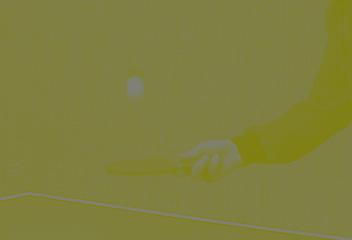


[EX1] Writing to /content/drive/My Drive/CSM/isel_leim_csm_1819/projects/P04/resources/encoded/exercise_01/ball/bola_1_final.tiff
[EX1] Encoding Given YCC Frame 1


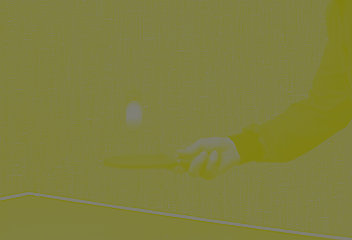


[EX1] Writing to /content/drive/My Drive/CSM/isel_leim_csm_1819/projects/P04/resources/encoded/exercise_01/ball/bola_2_final.tiff
[EX1] Encoding Given YCC Frame 2


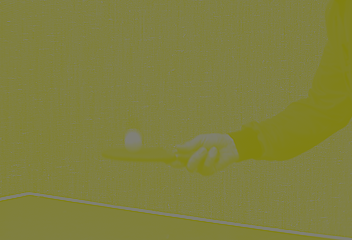


[EX1] Writing to /content/drive/My Drive/CSM/isel_leim_csm_1819/projects/P04/resources/encoded/exercise_01/ball/bola_3_final.tiff
[EX1] Total Encoding Time: 0.39147353172302246 seconds
[EX1] Encoded Frames: ['bola_1.tiff', 'bola_11.tiff', 'bola_4.tiff', 'bola_10.tiff', 'bola_3.tiff', 'bola_8.tiff', 'bola_5.tiff', 'bola_6.tiff', 'bola_7.tiff', 'bola_2.tiff', 'bola_9.tiff']
[EX1] Encoded Video Size: 954.596 kbytes

[EX1] Reading Frame 0


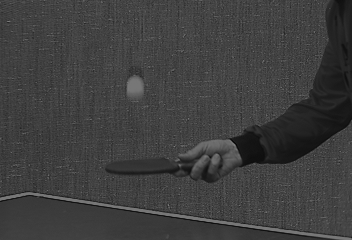

[EX1] Analysing Encoding Stats on Frame 0
[EX1] 1 . Compression Rate: Original Size 84.314 kbytes | Compressed Size 86.52 kbytes | Compression Rate -3.0%
[EX1] 2 . SNR on Frame -14.758434993925324: dB

[EX1] Reading Frame 1


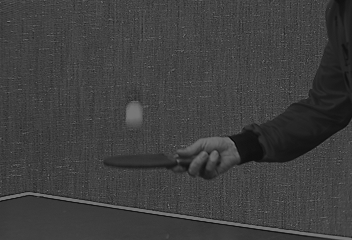

[EX1] Analysing Encoding Stats on Frame 1
[EX1] 1 . Compression Rate: Original Size 84.352 kbytes | Compressed Size 86.616 kbytes | Compression Rate -3.0%
[EX1] 2 . SNR on Frame -14.747001291672255: dB

[EX1] Reading Frame 2


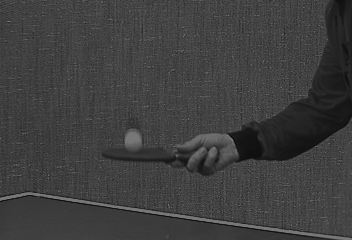

[EX1] Analysing Encoding Stats on Frame 2
[EX1] 1 . Compression Rate: Original Size 84.312 kbytes | Compressed Size 86.752 kbytes | Compression Rate -3.0%
[EX1] 2 . SNR on Frame -14.765277815118464: dB
[EX1] Total Decoding Time: 0.20128107070922852 seconds
[EX1] Decoded Frames: ['bola_4_final.tiff', 'bola_9_final.tiff', 'bola_5_final.tiff', 'bola_10_final.tiff', 'bola_6_final.tiff', 'bola_11_final.tiff', 'bola_7_final.tiff', 'bola_8_final.tiff', 'bola_1_final.tiff', 'bola_2_final.tiff', 'bola_3_final.tiff']
[EX1] Decoding Video Size: 1154.036 kbytes


In [42]:
#@title *MPEG Encoder::EX1*
Movie = 'ball' #@param ['ball', 'car']
Quality = '50' #@param ['100', '50', '10']
x = MPEG(Encoder_EX1(), Notebook.RESOURCES + Movie + '/', Notebook.ENCODED + 'exercise_01/' + Movie + '/', Notebook.DECODED + 'exercise_01/' + Movie + '/', Quality)

In [0]:
class Encoder_EX2(Encoder):
    def __init__(self):
        self.__encoding_iframe = True
        self.__decoding_iframe = True
        self.__iframe = 0
    
    def encode(self, frame: np.ndarray, output: str, quality: int, index: int):
        print('[EX1] Encoding Given YCC Frame {}'.format(index))
        cv2_imshow(frame)
        print()
        
        if self.__encoding_iframe:
            self.__encoding_iframe = False
            self.__iframe = YCCFrame(frame, index)
            self.__iframe.pixels = self.__iframe.pixels.astype(np.uint8)
            self.__iframe.write(output, int(quality))
            print("[EX1] Writing to {}".format(output))
        else:
            pframe = YCCFrame(YCCFrame(frame, index) - self.__iframe, index)
            pframe.pixels = ((pframe.pixels + 255) / 2.).astype(np.uint8)
            pframe.write(output, int(quality))
            print("[EX1] Writing to {}".format(output))
       
    def decode(self, src: str, index: int) -> np.ndarray:
        pframe = cv2.imread(src)
        if self.__decoding_iframe:
            self.__decoding_iframe = False
            self.__iframe = pframe
            return self.__iframe
        else:
            return (((pframe * 2 ) - 255 ) + self.__iframe)  

[EX1] Original Video Size: 927.032 kbytes
[EX1] Encoding Given YCC Frame 0


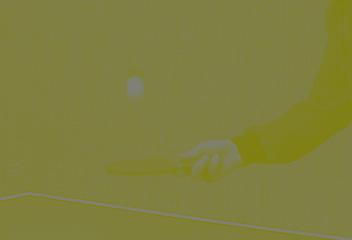


[EX1] Writing to /content/drive/My Drive/CSM/isel_leim_csm_1819/projects/P04/resources/encoded/exercise_02/ball/bola_1_final.tiff
[EX1] Encoding Given YCC Frame 1


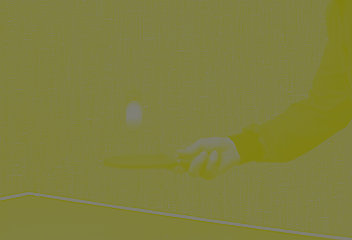


[EX1] Writing to /content/drive/My Drive/CSM/isel_leim_csm_1819/projects/P04/resources/encoded/exercise_02/ball/bola_2_final.tiff
[EX1] Encoding Given YCC Frame 2


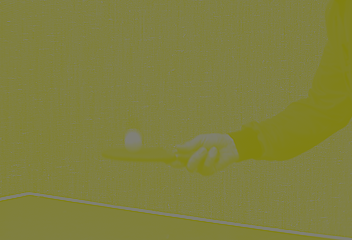


[EX1] Writing to /content/drive/My Drive/CSM/isel_leim_csm_1819/projects/P04/resources/encoded/exercise_02/ball/bola_3_final.tiff
[EX1] Total Encoding Time: 0.8989715576171875 seconds
[EX1] Encoded Frames: ['bola_1.tiff', 'bola_11.tiff', 'bola_4.tiff', 'bola_10.tiff', 'bola_3.tiff', 'bola_8.tiff', 'bola_5.tiff', 'bola_6.tiff', 'bola_7.tiff', 'bola_2.tiff', 'bola_9.tiff']
[EX1] Encoded Video Size: 683.13 kbytes

[EX1] Reading Frame 0


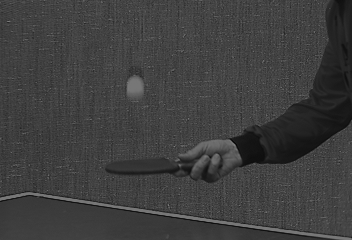

[EX1] Analysing Encoding Stats on Frame 0
[EX1] 1 . Compression Rate: Original Size 84.314 kbytes | Compressed Size 86.52 kbytes | Compression Rate -3.0%
[EX1] 2 . SNR on Frame -14.758434993925324: dB

[EX1] Reading Frame 1


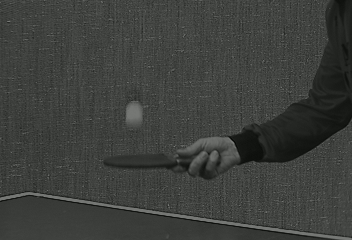

[EX1] Analysing Encoding Stats on Frame 1
[EX1] 1 . Compression Rate: Original Size 84.352 kbytes | Compressed Size 50.888 kbytes | Compression Rate 40.0%
[EX1] 2 . SNR on Frame -14.805237793001352: dB

[EX1] Reading Frame 2


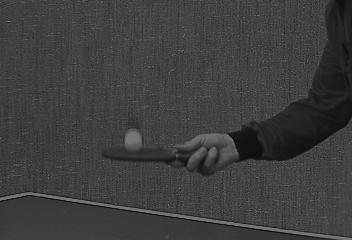

[EX1] Analysing Encoding Stats on Frame 2
[EX1] 1 . Compression Rate: Original Size 84.312 kbytes | Compressed Size 51.422 kbytes | Compression Rate 39.0%
[EX1] 2 . SNR on Frame -14.806396771575002: dB
[EX1] Total Decoding Time: 0.42263245582580566 seconds
[EX1] Decoded Frames: ['bola_6_final.tiff', 'bola_4_final.tiff', 'bola_7_final.tiff', 'bola_5_final.tiff', 'bola_8_final.tiff', 'bola_9_final.tiff', 'bola_10_final.tiff', 'bola_11_final.tiff', 'bola_1_final.tiff', 'bola_2_final.tiff', 'bola_3_final.tiff']
[EX1] Decoding Video Size: 1164.848 kbytes


In [44]:
#@title *MPEG Encoder::EX2*
Movie = 'ball' #@param ['ball', 'car']
Quality = '50' #@param ['100', '50', '10']
x = MPEG(Encoder_EX2(), Notebook.RESOURCES + Movie + '/', Notebook.ENCODED + 'exercise_02/' + Movie + '/', Notebook.DECODED + 'exercise_02/' + Movie + '/', Quality)

In [0]:
class Encoder_EX3(Encoder):
    def __init__(self, search_strategy: SearchStrategy) -> None:
        self.__search_strategy = search_strategy
        self.__encoding_iframe = True
        self.__decoding_iframe = True
        self.__movie_vectors = []
        self.__iframe = 0
        
    def encode(self, frame: np.ndarray, output: str, quality: int, index: int) -> None:
        print('[EX1] Encoding Given YCC Frame {}'.format(index))
        cv2_imshow(frame)
        print()
        
        if self.__encoding_iframe:
            self.__encoding_iframe = False
            self.__iframe = YCCFrame(frame, index)
            self.__iframe.write(output, int(quality))
            print("[EX1] Writing to {}".format(output))
        else:
            frame = YCCFrame(frame, index)
            layers = frame.layers
            iframe_layers = self.__iframe.layers
            predicted_image = np.zeros(frame.size, dtype=int).reshape(frame.shape)
            predicted_image = np.zeros(frame.size, dtype=int).reshape(frame.shape)
            
            # List of origin and target vectors
            vectors = np.array([Vectors] * frame.layers.size)
            
            # Counter for stats
            iterations = 0
            #print(frame.shape)
            for l in range(layers.shape[0]):
                vectors[l] = Vectors(dict())
                previous_blocks = iframe_layers[l].blocks
                #print(previous_blocks.shape)
                for r in range(previous_blocks.shape[0]):
                    for c in range(previous_blocks.shape[1]):
                        iterations +=1
                        
                        # Search for block in iframe
                        similar_block: Block = self.__search_strategy.find_similar(
                            previous_blocks[r, c], layers[l])[0]
                        r2, c2 = similar_block.origin[0]
                        
                        #if (c == 21 and r == 14 or c == 43 and r == 29):
                        #    print(previous_blocks[r, c].origin[0])
                        #    print('r2: ' + str())
                        #    print('c2: ' + str(c2))
                        
                        # Predict found block
                        r3 = r2 + similar_block.size
                        c3 = c2 + similar_block.size
                        previous_blocks[r, c].target = r2, c2
                        predicted_image[r2 : r3, c2 : c3, l] = previous_blocks[r, c].pixels
                        
                        # Collect origin and target vector
                        vector_index = (r, c)
                        vectors[l][vector_index] = (previous_blocks[r, c].origin[0], 
                                                    previous_blocks[r, c].target)
                        
            # Store prediction vectors
            self.__movie_vectors.append(vectors)
            
            # Setting YCC error frame (dispensing chrominance error with zeros)
            error_frame = YCCFrame(frame.pixels - predicted_image, frame.index)
            error_frame.pixels = (error_frame.pixels).astype(np.uint8)
            error_frame.pixels[:,:,1:] = 0
            
            # Setting YCC prediction frame
            predicted_frame = YCCFrame(predicted_image, frame.index)
            predicted_frame.pixels = (predicted_frame.pixels).astype(np.uint8) 
            
            # Writting error frame
            output_error = output.split('.')[-2] + '_error.' + output.split('.')[-1]
            error_frame.write(output_error, int(quality))
            print('[EX1] Writing to {}'.format(output_error))
            print('[EX1] Written Error Frame {}'.format(index))
            cv2_imshow(error_frame.pixels)
            print()
            
            # Writting prediction frame
            output_prediction = output.split('.')[-2] + '_prediction.' + output.split('.')[-1]
            predicted_frame.write(output_prediction, int(quality))
            print('[EX1] Writing to {}'.format(output_prediction))
            print('[EX1] Written Predicted Frame {}'.format(index))
            #cv2_imshow(predicted_frame.pixels[:,:len(predicted_frame.pixels[0])-16])
            cv2_imshow(predicted_frame.pixels)
            print()
            
            print("[EX1] Stats: {} iterations for frame nr. {} ({}x{}).".format(
                iterations, frame.index, frame.shape[0], frame.shape[1]))

    def decode(self, src: str, index: int) -> np.ndarray:
        pframe = cv2.imread(src)
        if self.__decoding_iframe:
            self.__decoding_iframe = False
            self.__iframe = YCCFrame(pframe, index)
            return self.__iframe.pixels.astype(np.uint8)
        else:       
            previous_layers = self.__iframe.layers
            predicted_image = np.zeros(self.__iframe.size, dtype=np.uint8).reshape(
                self.__iframe.shape)
            for l in range(previous_layers.shape[0]):
                previous_blocks = previous_layers[l].blocks
                block_size = previous_layers[l].BLOCK_SIZE
                for r in range(previous_blocks.shape[0]):
                    for c in range(previous_blocks.shape[1]):
                        vector_index = (r, c)
                        r2, c2 = self.__movie_vectors[index - 1][l][vector_index][1]
                        r3 = r2 + block_size
                        c3 = c2 + block_size
                        predicted_image[r2: r3, c2: c3, l] = previous_blocks[r, c].pixels
            
            error_frame_path = src.split('.')[-2] + '_error.' + src.split('.')[-1]
            assert os.path.isfile(error_frame_path), 'Error frame not found.'
            error_frame = cv2.imread(error_frame_path).astype(int)
            predicted_frame = error_frame + predicted_image
            return predicted_frame.astype(np.uint8)  

[EX1] Original Video Size: 927.032 kbytes
[EX1] Encoding Given YCC Frame 0


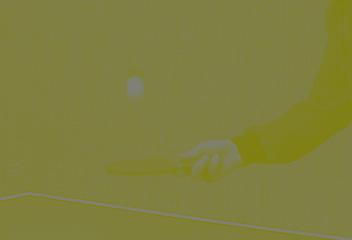


[EX1] Writing to /content/drive/My Drive/CSM/isel_leim_csm_1819/projects/P04/resources/encoded/exercise_03/ball/bola_1_final.tiff
[EX1] Encoding Given YCC Frame 1


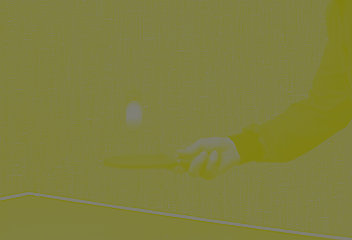


[EX1] Writing to /content/drive/My Drive/CSM/isel_leim_csm_1819/projects/P04/resources/encoded/exercise_03/ball/bola_2_final_error.tiff
[EX1] Written Error Frame 1


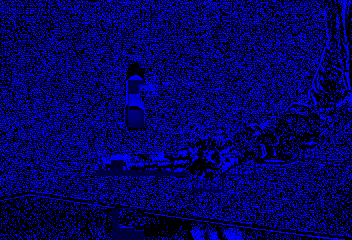


[EX1] Writing to /content/drive/My Drive/CSM/isel_leim_csm_1819/projects/P04/resources/encoded/exercise_03/ball/bola_2_final_prediction.tiff
[EX1] Written Predicted Frame 1


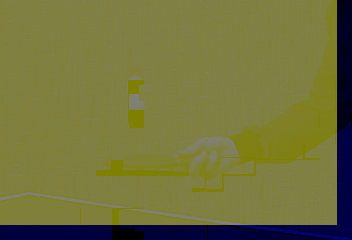


[EX1] Stats: 2970 iterations for frame nr. 1 (240x352).
[EX1] Encoding Given YCC Frame 2


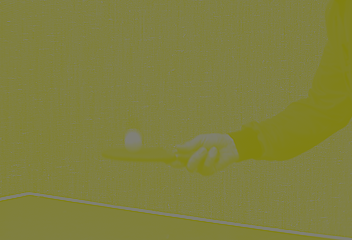


[EX1] Writing to /content/drive/My Drive/CSM/isel_leim_csm_1819/projects/P04/resources/encoded/exercise_03/ball/bola_3_final_error.tiff
[EX1] Written Error Frame 2


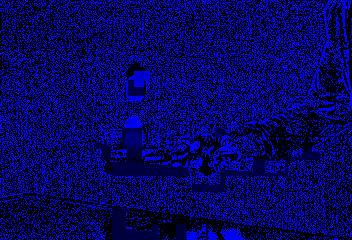


[EX1] Writing to /content/drive/My Drive/CSM/isel_leim_csm_1819/projects/P04/resources/encoded/exercise_03/ball/bola_3_final_prediction.tiff
[EX1] Written Predicted Frame 2


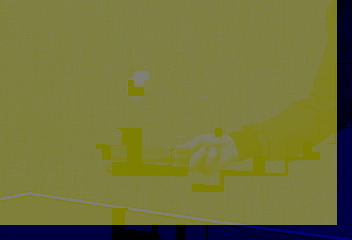


[EX1] Stats: 2970 iterations for frame nr. 2 (240x352).
[EX1] Total Encoding Time: 62.022013425827026 seconds
[EX1] Encoded Frames: ['bola_1.tiff', 'bola_11.tiff', 'bola_4.tiff', 'bola_10.tiff', 'bola_3.tiff', 'bola_8.tiff', 'bola_5.tiff', 'bola_6.tiff', 'bola_7.tiff', 'bola_2.tiff', 'bola_9.tiff']
[EX1] Encoded Video Size: 392.512 kbytes

[EX1] Reading Frame 0


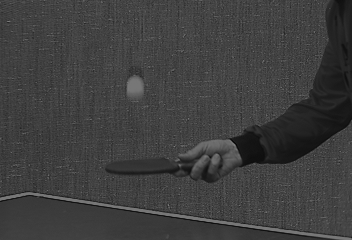

[EX1] Analysing Encoding Stats on Frame 0
[EX1] 1 . Compression Rate: Original Size 84.314 kbytes | Compressed Size 86.52 kbytes | Compression Rate -3.0%
[EX1] 2 . SNR on Frame -14.758434993925324: dB

[EX1] Reading Frame 1


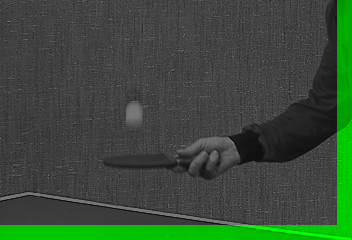

[EX1] Analysing Encoding Stats on Frame 1
[EX1] 1 . Compression Rate: Original Size 84.352 kbytes | Compressed Size 66.36 kbytes | Compression Rate 21.0%
[EX1] 2 . SNR on Frame -15.667289436172451: dB

[EX1] Reading Frame 2


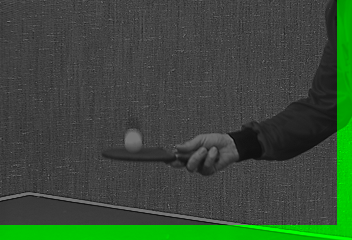

[EX1] Analysing Encoding Stats on Frame 2
[EX1] 1 . Compression Rate: Original Size 84.312 kbytes | Compressed Size 67.706 kbytes | Compression Rate 20.0%
[EX1] 2 . SNR on Frame -15.685494897596184: dB
[EX1] Total Decoding Time: 0.612041711807251 seconds
[EX1] Decoded Frames: ['bola_1_final.tiff', 'bola_2_final_error.tiff', 'bola_2_final_prediction.tiff', 'bola_3_final_error.tiff', 'bola_3_final_prediction.tiff']
[EX1] Decoding Video Size: 318.978 kbytes


In [41]:
#@title *MPEG Encoder::EX3*
Movie = 'ball' #@param ['ball', 'car']
Quality = '10' #@param ['100', '50', '10']
Search = 'Exhaustive' #@param ['Exhaustive', 'Iterative']
if(Search=='Exhaustive'):
    x = MPEG(Encoder_EX3(Exhaustive()), Notebook.RESOURCES + Movie + '/', Notebook.ENCODED + 'exercise_03/' + Movie + '/', Notebook.DECODED + 'exercise_03/' + Movie + '/', Quality)
elif(Search=='Iterative'):
    x = MPEG(Encoder_EX3(Iterative()), Notebook.RESOURCES + Movie + '/', Notebook.ENCODED + 'exercise_03/' + Movie + '/', Notebook.DECODED + 'exercise_03/' + Movie + '/', Quality)    